In [1]:
import torch
from torch.utils.data import DataLoader
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
import seaborn as sns
from tqdm import tqdm
import matplotlib.pyplot as plt
import warnings
import umap

from pandas.core.common import SettingWithCopyWarning

import cellshape_cloud as cscloud
from cellshape_cloud.pointcloud_dataset import (
    PointCloudDataset,
    SingleCellDataset,
)
from cellshape_cloud.cloud_autoencoder import CloudAutoEncoder
from cellshape_cloud.vendor.chamfer_distance import ChamferLoss

import cellshape_cluster as cscluster
from cellshape_cluster.deep_embedded_clustering import DeepEmbeddedClustering

In [2]:
# Define all the arguements
model_path = "/home/mvries/Documents/CellShape/UploadData/Models/cloud_dec/dgcnn_foldingnetDECAll_128_005_updated.pt"
points_dir = "/home/mvries/Documents/CellShape/UploadData/Dataset/"
annotations_file = points_dir + "all_data_removedwrong_ori_removedTwo.csv"
num_features = 128
k = 20
encoder_type = "dgcnn"
decoder_type = "foldingnetbasic"
cell_component = "cell"

In [3]:
# Define the models and load the weights
autoencoder = CloudAutoEncoder(
    num_features=num_features,
    k=k,
    encoder_type=encoder_type,
    decoder_type=decoder_type,
)

checkpoint = torch.load(model_path)
num_clusters = checkpoint["model_state_dict"]["clustering_layer.weight"].shape[
    0
]

print(f"The number of clusters in the loaded model is: {num_clusters}")

model = DeepEmbeddedClustering(
    autoencoder=autoencoder, num_clusters=num_clusters
)

model.load_state_dict(checkpoint["model_state_dict"])

# Move the model to the gpu if there is one available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)

# Put the model in evaluation mode
model.eval()

# Define the datasets
dataset = SingleCellDataset(
    annotations_file=annotations_file,
    points_dir=points_dir,
    cell_component=cell_component,
)

dataloader = DataLoader(dataset, batch_size=1, shuffle=False)

The number of clusters in the loaded model is: 5


In [4]:
# Extract features and clusters

all_feat = []
all_labels = []
all_serial_numbers = []
all_clusters = []
for data in tqdm(dataloader):

    inputs = data[0]
    lab = data[1]
    ser_num = data[3]
    inputs = inputs.to(device)
    batch_size = inputs.shape[0]

    output, features, clusters = model(inputs)
    all_feat.append(torch.squeeze(features).detach().cpu().numpy())
    all_clusters.append(torch.squeeze(clusters).detach().cpu().numpy())
    all_labels.append(lab[0])
    all_serial_numbers.append(ser_num[0])

100%|████████████████████████████████████| 65500/65500 [10:32<00:00, 103.51it/s]


/tmp/ipykernel_569254/220242146.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cluster_treatment_df['WellNumber'][i] = str(cluster_treatment_df['PlateNumber'][i]) + cluster_treatment_df['Row'][i] + str(cluster_treatment_df['Column'][i])


<Figure size 720x720 with 0 Axes>

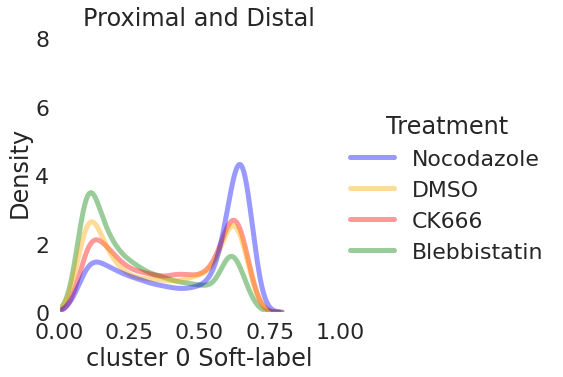

<Figure size 720x720 with 0 Axes>

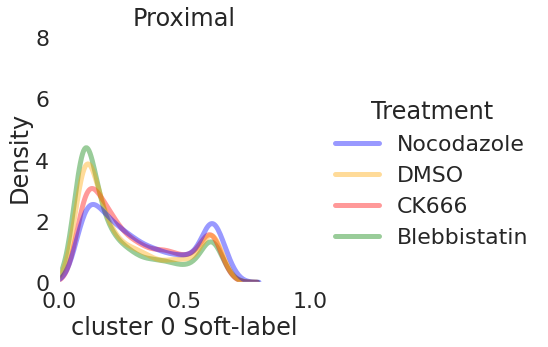

<Figure size 720x720 with 0 Axes>

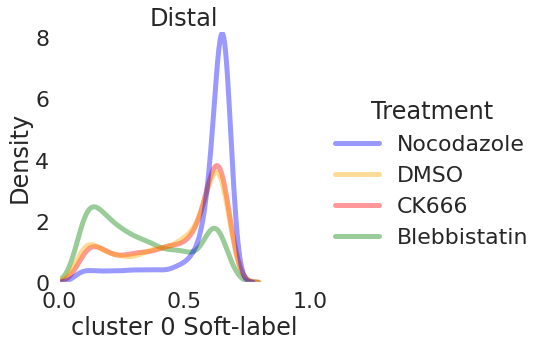

In [5]:
cluster_predictions = np.argmax(np.asarray(all_clusters).data, axis=1)
folding_data = pd.DataFrame(np.asarray(all_feat))
folding_data["serialNumber"] = np.asarray(all_serial_numbers)
folding_data["cluster_labels"] = np.asarray(cluster_predictions)
df = "/home/mvries/Documents/Datasets/OPM/SingleCellFromNathan_17122021/all_data_removedwrong_ori_removedTwo.csv"

all_data = pd.read_csv(annotations_file)
all_data_labels = all_data[
    [
        "serialNumber",
        "Treatment",
        "Proximal",
        "nucleusCoverslipDistance",
        "erkRatio",
        "erkIntensityNucleus",
        "erkIntensityCell",
        "Volume_cell",
        "EquivDiameter_cell",
        "SurfaceArea_cell",
        "MeanIntensity_cell",
        "MinIntensity_cell",
        "MaxIntensity_cell",
        "AxialExtent_cell",
        "MajorAxis_cell",
        "MinorAxis_cell",
        "secondMajor_cell",
        "Eccentricity_cell",
        "secondEccentricity_cell",
        "Azimuth_cell",
        "Pitch_cell",
        "absPitch_cell",
        "Sphericity_cell",
        "Vol2surf_cell",
        "zOrbit",
        "Orbit",
        "AngleBetween",
        "nProtrusions_cell",
        "Polarity_cell",
        "Spreading_cell",
        "Protrusivity_cell",
        "yaw",
        "roll",
        "pitch",
        "Row",
        "Column",
        "PlateNumber",
    ]
].reset_index(drop=True)
folding_data_new = folding_data.join(
    all_data_labels.set_index("serialNumber"), on="serialNumber"
)
folding_data_new


all_clusters_np = np.asarray(all_clusters)
cluster_treatment_df = pd.DataFrame(all_clusters_np)
cluster_treatment_df["Treatment"] = np.asarray(all_labels)
cluster_treatment_df.columns = [
    "Cluster0",
    "Cluster1",
    "Cluster2",
    "Cluster3",
    "Cluster4",
    "Treatment",
]
cluster_treatment_df["Proximal"] = folding_data_new["Proximal"].values
cluster_treatment_df["Row"] = folding_data_new["Row"].values
cluster_treatment_df["Column"] = folding_data_new["Column"].values
cluster_treatment_df["PlateNumber"] = folding_data_new["PlateNumber"].values
cluster_treatment_df["WellNumber"] = cluster_treatment_df["PlateNumber"].values

for i in range(len(cluster_treatment_df["PlateNumber"])):
    cluster_treatment_df["WellNumber"][i] = (
        str(cluster_treatment_df["PlateNumber"][i])
        + cluster_treatment_df["Row"][i]
        + str(cluster_treatment_df["Column"][i])
    )

scalar = StandardScaler()
scaled_clusters = scalar.fit_transform(
    np.asarray(cluster_treatment_df.iloc[:, :5])
)
scaled_first_df = pd.DataFrame(scaled_clusters)
scaled_first_df["Treatment"] = cluster_treatment_df["Treatment"].values

sns.set(font_scale=2)
plt.rcParams["axes.facecolor"] = "white"
plt.figure(figsize=(10, 10))
sns_data = pd.DataFrame(
    cluster_treatment_df[
        (cluster_treatment_df["Treatment"] == "Nocodazole")
        | (cluster_treatment_df["Treatment"] == "Blebbistatin")
        | (cluster_treatment_df["Treatment"] == "DMSO")
        | (cluster_treatment_df["Treatment"] == "CK666")
    ][["Cluster0", "Treatment"]]
)

colors = {
    "Blebbistatin": "green",
    "H1152": "lightgreen",
    "Nocodazole": "blue",
    "CK666": "red",
    "DMSO": "orange",
}
ax = sns.displot(
    sns_data,
    x="Cluster0",
    palette=colors,
    hue="Treatment",
    kind="kde",
    alpha=0.4,
    #                  bins=100,
    linewidth=5,
    common_norm=False,
)
ax.set(xlabel="cluster 0 Soft-label")
ax.set(xlim=(0, 1), ylim=(0, 8.2))
plt.title("Proximal and Distal")
fig = ax.figure


sns.set(font_scale=2)
plt.rcParams["axes.facecolor"] = "white"
plt.figure(figsize=(10, 10))
sns_data = pd.DataFrame(
    cluster_treatment_df[
        (
            (cluster_treatment_df["Treatment"] == "Nocodazole")
            | (cluster_treatment_df["Treatment"] == "Blebbistatin")
            | (cluster_treatment_df["Treatment"] == "DMSO")
            | (cluster_treatment_df["Treatment"] == "CK666")
        )
        & (cluster_treatment_df["Proximal"] == 1)
    ][["Cluster0", "Treatment"]]
)

colors = {
    "Blebbistatin": "green",
    "H1152": "lightgreen",
    "Nocodazole": "blue",
    "CK666": "red",
    "DMSO": "orange",
}
ax = sns.displot(
    sns_data,
    x="Cluster0",
    palette=colors,
    hue="Treatment",
    kind="kde",
    alpha=0.4,
    #                  bins=100,
    linewidth=5,
    common_norm=False,
)
ax.set(xlabel="cluster 0 Soft-label")
ax.set(xlim=(0, 1), ylim=(0, 8.2))
plt.title("Proximal")
fig = ax.figure

sns.set(font_scale=2)
plt.rcParams["axes.facecolor"] = "white"
plt.figure(figsize=(10, 10))
np.random.seed(42)
sns_data = pd.DataFrame(
    cluster_treatment_df[
        (
            (cluster_treatment_df["Treatment"] == "Nocodazole")
            | (cluster_treatment_df["Treatment"] == "Blebbistatin")
            | (cluster_treatment_df["Treatment"] == "DMSO")
            | (cluster_treatment_df["Treatment"] == "CK666")
        )
        & (cluster_treatment_df["Proximal"] == 0)
    ][["Cluster0", "Treatment"]]
)

colors = {
    "Blebbistatin": "green",
    "H1152": "lightgreen",
    "Nocodazole": "blue",
    "CK666": "red",
    "DMSO": "orange",
}
ax = sns.displot(
    sns_data,
    x="Cluster0",
    palette=colors,
    hue="Treatment",
    kind="kde",
    alpha=0.4,
    #                  bins=100,
    linewidth=5,
    common_norm=False,
)
ax.set(xlabel="cluster 0 Soft-label")
ax.set(xlim=(0, 1), ylim=(0, 8.2))
plt.title("Distal")
fig = ax.figure

<Figure size 720x720 with 0 Axes>

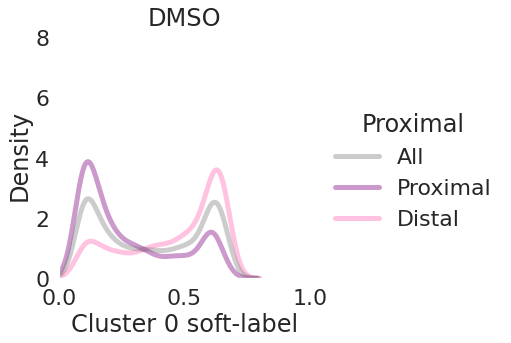

<Figure size 720x720 with 0 Axes>

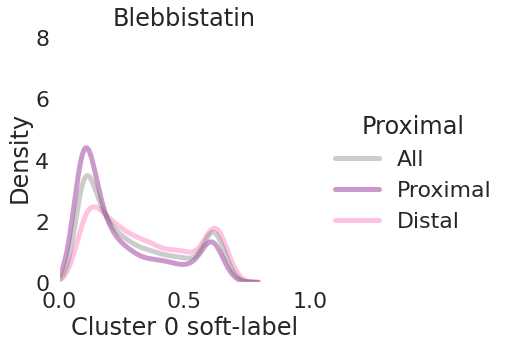

<Figure size 720x720 with 0 Axes>

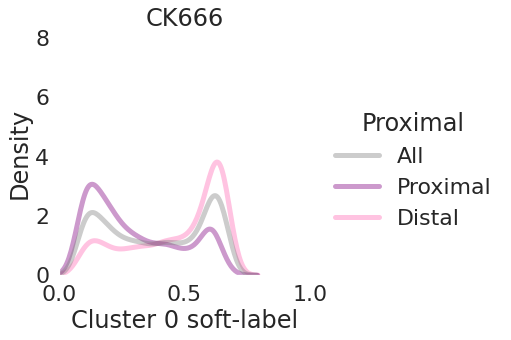

<Figure size 720x720 with 0 Axes>

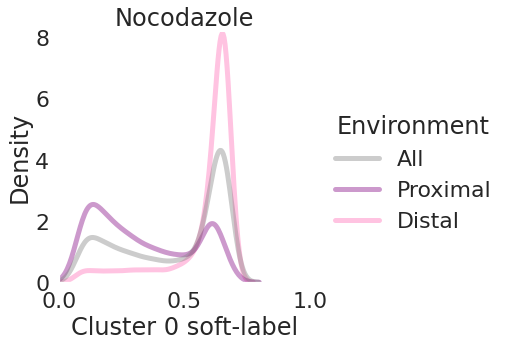

In [6]:
sns.set(font_scale=2)
plt.rcParams["axes.facecolor"] = "white"
plt.figure(figsize=(10, 10))
np.random.seed(42)
alldata = pd.DataFrame(
    cluster_treatment_df[(cluster_treatment_df["Treatment"] == "DMSO")][
        ["Cluster0", "Treatment"]
    ]
)
alldata["Proximal"] = "All"

proxdata = pd.DataFrame(
    cluster_treatment_df[
        (cluster_treatment_df["Treatment"] == "DMSO")
        & (cluster_treatment_df["Proximal"] == 1)
    ][["Cluster0", "Treatment"]]
)
proxdata["Proximal"] = "Proximal"

distdata = pd.DataFrame(
    cluster_treatment_df[
        (cluster_treatment_df["Treatment"] == "DMSO")
        & (cluster_treatment_df["Proximal"] == 0)
    ][["Cluster0", "Treatment"]]
)
distdata["Proximal"] = "Distal"

findata = pd.concat((alldata, proxdata, distdata), ignore_index=True)
findata

colors = {"All": "grey", "Proximal": "purple", "Distal": "hotpink"}
ax = sns.displot(
    findata,
    x="Cluster0",
    palette=colors,
    hue="Proximal",
    kind="kde",
    alpha=0.4,
    #                  bins=100,
    linewidth=5,
    common_norm=False,
)
ax.set(xlabel="Cluster 0 soft-label")
plt.title("DMSO")
ax.set(xlim=(0, 1), ylim=(0, 8.2))
fig = ax.figure


sns.set(font_scale=2)
plt.rcParams["axes.facecolor"] = "white"
plt.figure(figsize=(10, 10))
np.random.seed(42)
alldata = pd.DataFrame(
    cluster_treatment_df[
        (cluster_treatment_df["Treatment"] == "Blebbistatin")
    ][["Cluster0", "Treatment"]]
)
alldata["Proximal"] = "All"

proxdata = pd.DataFrame(
    cluster_treatment_df[
        (cluster_treatment_df["Treatment"] == "Blebbistatin")
        & (cluster_treatment_df["Proximal"] == 1)
    ][["Cluster0", "Treatment"]]
)
proxdata["Proximal"] = "Proximal"

distdata = pd.DataFrame(
    cluster_treatment_df[
        (cluster_treatment_df["Treatment"] == "Blebbistatin")
        & (cluster_treatment_df["Proximal"] == 0)
    ][["Cluster0", "Treatment"]]
)
distdata["Proximal"] = "Distal"

findata = pd.concat((alldata, proxdata, distdata), ignore_index=True)
findata

colors = {"All": "grey", "Proximal": "purple", "Distal": "hotpink"}
ax = sns.displot(
    findata,
    x="Cluster0",
    palette=colors,
    hue="Proximal",
    kind="kde",
    alpha=0.4,
    #                  bins=100,
    linewidth=5,
    common_norm=False,
)
ax.set(xlabel="Cluster 0 soft-label")
plt.title("Blebbistatin")
ax.set(xlim=(0, 1), ylim=(0, 8.2))
fig = ax.figure


sns.set(font_scale=2)
plt.rcParams["axes.facecolor"] = "white"
plt.figure(figsize=(10, 10))
np.random.seed(42)
alldata = pd.DataFrame(
    cluster_treatment_df[(cluster_treatment_df["Treatment"] == "CK666")][
        ["Cluster0", "Treatment"]
    ]
)
alldata["Proximal"] = "All"

proxdata = pd.DataFrame(
    cluster_treatment_df[
        (cluster_treatment_df["Treatment"] == "CK666")
        & (cluster_treatment_df["Proximal"] == 1)
    ][["Cluster0", "Treatment"]]
)
proxdata["Proximal"] = "Proximal"

distdata = pd.DataFrame(
    cluster_treatment_df[
        (cluster_treatment_df["Treatment"] == "CK666")
        & (cluster_treatment_df["Proximal"] == 0)
    ][["Cluster0", "Treatment"]]
)
distdata["Proximal"] = "Distal"

findata = pd.concat((alldata, proxdata, distdata), ignore_index=True)
findata

colors = {"All": "grey", "Proximal": "purple", "Distal": "hotpink"}
ax = sns.displot(
    findata,
    x="Cluster0",
    palette=colors,
    hue="Proximal",
    kind="kde",
    alpha=0.4,
    #                  bins=100,
    linewidth=5,
    common_norm=False,
)
ax.set(xlabel="Cluster 0 soft-label")
plt.title("CK666")
ax.set(xlim=(0, 1), ylim=(0, 8.2))
fig = ax.figure


sns.set(font_scale=2)
plt.rcParams["axes.facecolor"] = "white"
plt.figure(figsize=(10, 10))
np.random.seed(42)
alldata = pd.DataFrame(
    cluster_treatment_df[(cluster_treatment_df["Treatment"] == "Nocodazole")][
        ["Cluster0", "Treatment"]
    ]
)
alldata["Environment"] = "All"

proxdata = pd.DataFrame(
    cluster_treatment_df[
        (cluster_treatment_df["Treatment"] == "Nocodazole")
        & (cluster_treatment_df["Proximal"] == 1)
    ][["Cluster0", "Treatment"]]
)
proxdata["Environment"] = "Proximal"

distdata = pd.DataFrame(
    cluster_treatment_df[
        (cluster_treatment_df["Treatment"] == "Nocodazole")
        & (cluster_treatment_df["Proximal"] == 0)
    ][["Cluster0", "Treatment"]]
)
distdata["Environment"] = "Distal"

findata = pd.concat((alldata, proxdata, distdata), ignore_index=True)
findata

colors = {"All": "grey", "Proximal": "purple", "Distal": "hotpink"}
ax = sns.displot(
    findata,
    x="Cluster0",
    palette=colors,
    hue="Environment",
    kind="kde",
    alpha=0.4,
    #                  bins=100,
    linewidth=5,
    common_norm=False,
)
ax.set(xlabel="Cluster 0 soft-label")
plt.title("Nocodazole")
ax.set(xlim=(0, 1), ylim=(0, 8.2))
fig = ax.figure

<Figure size 720x1440 with 0 Axes>

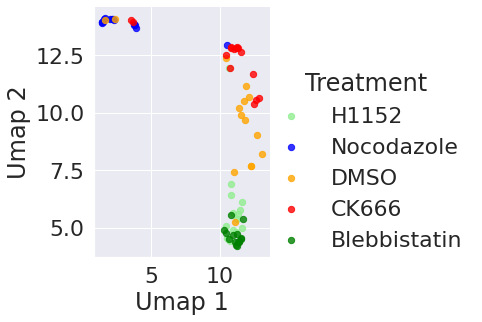

In [7]:
warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)

scaled_first_df = pd.DataFrame(scaled_clusters)
scaled_first_df["Treatment"] = cluster_treatment_df["Treatment"].values
scaled_first_df["WellNumber"] = cluster_treatment_df["WellNumber"].values
scaled_first_df["Column"] = cluster_treatment_df["Column"].values
scaled_first_df["PlateNumber"] = cluster_treatment_df["PlateNumber"].values

grouped_ct_scaled_first = scaled_first_df.groupby(["Treatment"]).mean()
wellgroup = scaled_first_df.groupby(["WellNumber"]).mean()

wellgroup["Treatment"] = str(wellgroup["Column"])
for i in range(len(wellgroup["Treatment"])):

    if wellgroup["Column"][i] == 2:
        wellgroup["Treatment"][i] = "Palbociclib"

    elif wellgroup["Column"][i] == 3:
        wellgroup["Treatment"][i] = "PF228"

    elif wellgroup["Column"][i] == 4:
        wellgroup["Treatment"][i] = "MK1775"

    elif wellgroup["Column"][i] == 5:
        wellgroup["Treatment"][i] = "Binimetinib"

    elif wellgroup["Column"][i] == 6:
        wellgroup["Treatment"][i] = "Nocodazole"

    elif wellgroup["Column"][i] == 7:
        wellgroup["Treatment"][i] = "DMSO"

    elif wellgroup["Column"][i] == 8:
        wellgroup["Treatment"][i] = "CK666"

    elif (wellgroup["Column"][i] == 9) & (
        (wellgroup["PlateNumber"][i] == 1) | (wellgroup["PlateNumber"][i] == 3)
    ):
        wellgroup["Treatment"][i] = "Blebbistatin"

    elif (wellgroup["Column"][i] == 9) & (wellgroup["PlateNumber"][i] == 2):
        wellgroup["Treatment"][i] = "H1152"

    elif (wellgroup["Column"][i] == 10) & (
        (wellgroup["PlateNumber"][i] == 1) | (wellgroup["PlateNumber"][i] == 3)
    ):
        wellgroup["Treatment"][i] = "H1152"

    elif (wellgroup["Column"][i] == 10) & (wellgroup["PlateNumber"][i] == 2):
        wellgroup["Treatment"][i] = "Blebbistatin"

    elif wellgroup["Column"][i] == 11:
        wellgroup["Treatment"][i] = "No Treatment"

reducer_well_signatures = umap.UMAP(
    random_state=1, n_neighbors=10, min_dist=0.0125
)
embedding_well_signatures = reducer_well_signatures.fit_transform(
    wellgroup.iloc[:, :5].values
)

sns.set(font_scale=2)
plt.figure(figsize=(10, 20))

b = np.zeros((len(embedding_well_signatures), 2))
b[:, 0] = embedding_well_signatures[:, 0]
b[:, 1] = embedding_well_signatures[:, 1]

data = pd.DataFrame(b, columns=["Umap 1", "Umap 2"])
data["Treatment"] = wellgroup["Treatment"].values

colors = {
    "Blebbistatin": "green",
    "H1152": "lightgreen",
    "Nocodazole": "blue",
    "CK666": "red",
    "DMSO": "orange",
}
facet = sns.lmplot(
    data=data[
        (data["Treatment"] == "Nocodazole")
        | (data["Treatment"] == "Blebbistatin")
        | (data["Treatment"] == "H1152")
        | (data["Treatment"] == "CK666")
        | (data["Treatment"] == "DMSO")
    ],
    x="Umap 1",
    y="Umap 2",
    hue="Treatment",
    fit_reg=False,
    legend=True,
    scatter_kws={"s": 40},
    palette=colors,
)


plt.show()

[Text(1, 0.5, 'Nocodazole'),
 Text(1, 1.5, 'Blebbistatin'),
 Text(1, 2.5, 'H1152'),
 Text(1, 3.5, 'CK666'),
 Text(1, 4.5, 'PF228'),
 Text(1, 5.5, 'Palbociclib'),
 Text(1, 6.5, 'MK1775'),
 Text(1, 7.5, 'No Treatment'),
 Text(1, 8.5, 'Binimetinib'),
 Text(1, 9.5, 'DMSO')]

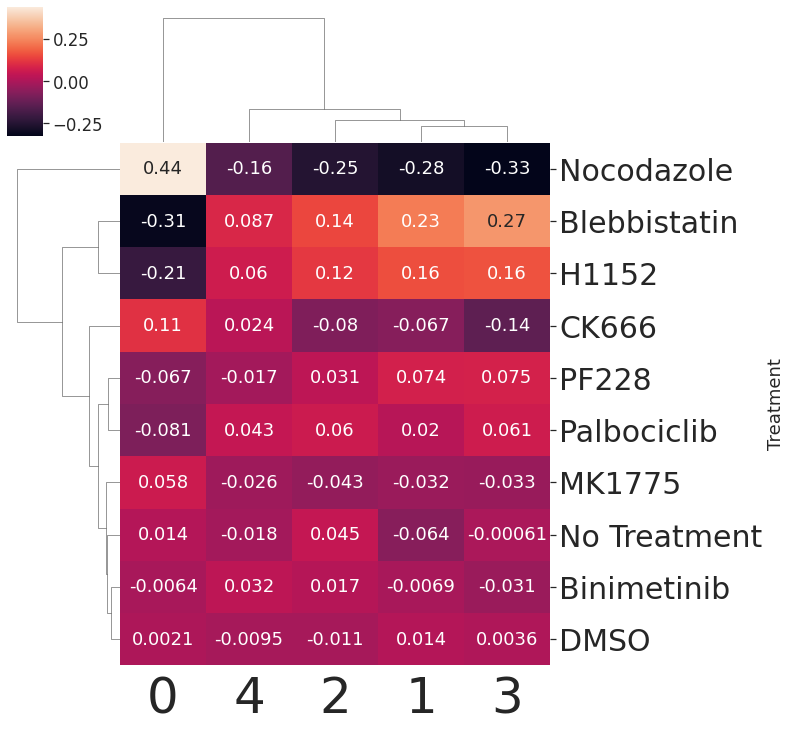

In [8]:
sns.set(rc={"figure.figsize": (20.7, 8.27)})
sns.set(font_scale=1.5)

ax = sns.clustermap(grouped_ct_scaled_first.iloc[:, :5], annot=True)
ax.ax_heatmap.set_xticklabels(
    ax.ax_heatmap.get_xmajorticklabels(), fontsize=50
)
ax.ax_heatmap.set_yticklabels(
    ax.ax_heatmap.get_ymajorticklabels(), fontsize=30
)